In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import TABLEAU_COLORS

sys.path.append('..')
from notebook_utils import Data, train, run_study, test_vanilla, test_uncertain

sys.path.append('../../..')
from uncertain.pairwise_ranking.MF import bprMF, UncertainMF, PretrainedUncertainMF
from uncertain.extras import Resample

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'Data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_table('Behance_appreciate_1M', sep=' ', header=None)
    data.columns = ['user', 'item', 'timestamps']
    
    # Drop items with < 5 ratings
    length = data.item.value_counts()
    data.drop(data.index[data.item.isin(length.index[length < 5])], 0, inplace=True)
    
    # Drop user with < 20 ratings
    length = data.user.value_counts().drop(columns='timestamps')
    data.drop(data.index[data.user.isin(length.index[length < 5])], 0, inplace=True)
    
    data = Data(data.drop(columns='timestamps'))
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=5)
        
base_conf = {'embedding_dim':1, 'lr':0, 'weight_decay':0}
trials = 20 ## 0 for eval only mode

Data prepared: 23971 users, 32489 items.
427791 train, 131146 validation and 139183 test interactions.


In [2]:
f'batch size: ({2**8}, {2**10}) - learning rate: ({1e-5}, {1e-3} - weight_decay: {1e-5, 1e-3})'

'batch size: (256, 1024) - learning rate: (1e-05, 0.001 - weight_decay: (1e-05, 0.001))'

# MF-BPR

In [4]:
name = 'MF-BPR'
def init_model(**kwargs):
    return bprMF(data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**8, 2**10)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3)}
    '''
    'weight_decay': (trial.suggest_float('wd_user', 1e-4, 1e-2), 
                     trial.suggest_float('wd_item', 1e-4, 1e-2), 
                     trial.suggest_float('wd_neg_item', 1e-4, 1e-2))
    '''
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
baseline = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(baseline, data, max_k=10, name=name)

clear_output(wait=True)
print(best_runs.user_attrs_filename.iloc[0])
print(results)
best_runs

/home/vcoscrato/Documents/RecSys/MF/tests/Pairwise/Behance/checkpoints/MF-BPR/bs = 862-embedding_dim=200-lr=0.0003760592901110748-weight_decay=0.00011031321227358209-epoch=89-val_likelihood=0.8457652926445007.ckpt
{'FCP': 0.8703864696119498, 'MAP': array([0.03983981, 0.05281382, 0.0591861 , 0.06319904, 0.0659565 ,
       0.06812812, 0.06952083, 0.07064691, 0.07148521, 0.07212137],
      dtype=float32), 'Recall': array([0.01247779, 0.02091547, 0.02704511, 0.03229878, 0.03749748,
       0.04234244, 0.04642131, 0.05087615, 0.05398714, 0.05791683],
      dtype=float32)}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
0,0,0.845765,2022-07-04 18:06:08.286811,2022-07-04 18:20:59.967959,0 days 00:14:51.681148,862,200,0.000376,0.00011,/home/vcoscrato/Documents/RecSys/MF/tests/Pair...,COMPLETE


In [5]:
baseline.recommend(0, n=100000)

,scores
15349,7.484874
9271,7.478933
20524,7.454004
26936,7.408309
14080,7.374285
...,...
23352,-6.665391
21441,-6.786464
10840,-6.847859
22064,-7.210838


# Resample

In [ ]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 'weight_decay': best_params['wd']}

# Train
if trials > 0:
    og = deepcopy(data.train)
    for i in range(5):
        data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
        model = init_model(**best_params)
        train(model, data, path='checkpoints/resample', name=f'{i}')
    data.train = og
    
# Load resample models
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0]), models)
results_resample = test_uncertain(resample, data, name='RESAMPLE', max_k=10)
clear_output(wait=True)
results_resample

In [ ]:
model.recommend(0, n=100000)

# UMF-GPR

In [ ]:
name = 'UMF-GPR-notailchasing'

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 2**8, 2**10)
    params = {'embedding_dim': trial.suggest_int('dim', 200, 200),
              'embedding_dim_var': trial.suggest_int('dim_var', 5, 50),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-6, 1e-4)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = UncertainMF(data.n_user, data.n_item, **params)
    
    # Freeze uncertainty
    for param in model.user_var.parameters():
        param.requires_grad = False
    for param in model.item_var.parameters():
        param.requires_grad = False
     
    _, path = train(model, data, path='checkpoints/' + name, name=params_str)
    model.load_from_checkpoint(path)
    
    # Unfreeze uncertainty
    for param in model.user_var.parameters():
        param.requires_grad = True
    for param in model.item_var.parameters():
        param.requires_grad = True
        
    # Freeze mean
    for param in model.user_mean.parameters():
        param.requires_grad = False
    for param in model.item_mean.parameters():
        param.requires_grad = False
    
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
print(best_runs.user_attrs_filename.iloc[0])
print(results)
best_runs

{'FCP': 0.8712199047297443, 'CP unc': 0.3541425, 'DP unc': 0.5650556, 'PUR': 0.6267392, 'corr_usup': -0.2822178260664696, 'corr_isup': -0.6957429711715692, 'MAP': array([0.02815903, 0.03721163, 0.04260008, 0.04549595, 0.04762467,
       0.04897332, 0.05033084, 0.05109673, 0.051766  , 0.05233752],
      dtype=float32), 'Recall': array([0.00729461, 0.01184546, 0.01682681, 0.0200989 , 0.02339345,
       0.02642228, 0.02955442, 0.03241082, 0.03480719, 0.03794096],
      dtype=float32), 'UAC': -0.2084407546448919, 'URI': 0.027952346950769424, 'MAP-covered': array([0.05233753, 0.05188851, 0.05513733, 0.05942863, 0.06522201,
       0.07282671, 0.08272933, 0.09683369, 0.11739148, 0.15154021])}


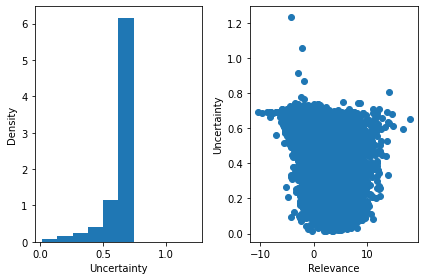

In [2]:
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint('checkpoints/UMF-GPR-notailchasing/bs = 316-embedding_dim=200-embedding_dim_var=35-lr=0.0001627213424377865-weight_decay=2.071827037209676e-05-epoch=79-val_likelihood=0.8618765473365784.ckpt')
results = test_uncertain(model, data, max_k=10, name='UMF-GPR-run0')

clear_output(wait=True)
print(results)

{'FCP': 0.8703721000409532, 'CP unc': 0.2873206, 'DP unc': 0.5196562, 'PUR': 0.5529052, 'corr_usup': -0.25977693728668594, 'corr_isup': -0.6616342447157282, 'MAP': array([0.0322473 , 0.04232197, 0.04811022, 0.05172569, 0.05431934,
       0.05602443, 0.05735076, 0.05829054, 0.05900062, 0.05954598],
      dtype=float32), 'Recall': array([0.008672  , 0.01437409, 0.01911598, 0.02365644, 0.0280237 ,
       0.03193565, 0.0353412 , 0.0384189 , 0.04115579, 0.04389982],
      dtype=float32), 'UAC': -0.19124364133525662, 'URI': -0.07672195881605148, 'MAP-covered': array([0.05954598, 0.05803209, 0.06113899, 0.06571592, 0.07163084,
       0.07947363, 0.08913855, 0.1032731 , 0.12222599, 0.16152937])}


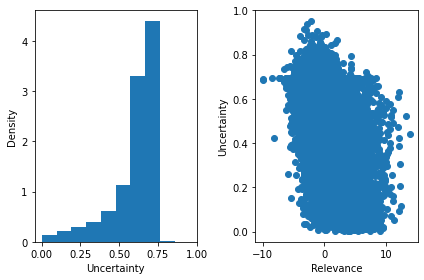

In [4]:
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint('checkpoints/UMF-GPR-notailchasing/bs = 661-embedding_dim=200-embedding_dim_var=46-lr=0.00045353614933719977-weight_decay=3.6422899815980574e-05-epoch=79-val_likelihood=0.8612967729568481.ckpt')
results = test_uncertain(model, data, max_k=10, name='UMF-GPR-run1')

clear_output(wait=True)
print(results)

{'FCP': 0.8715072961496735, 'CP unc': 0.402321, 'DP unc': 0.58626544, 'PUR': 0.6862438, 'corr_usup': -0.25257979399000796, 'corr_isup': -0.6457508931363244, 'MAP': array([0.03487547, 0.0465354 , 0.05204205, 0.05521718, 0.05762257,
       0.05930839, 0.06055888, 0.06143879, 0.06210003, 0.0627098 ],
      dtype=float32), 'Recall': array([0.00917527, 0.01593481, 0.02088733, 0.02489982, 0.02895533,
       0.0323455 , 0.0360267 , 0.03951301, 0.04252816, 0.0452717 ],
      dtype=float32), 'UAC': -0.17447236164446192, 'URI': -0.0179173331707716, 'MAP-covered': array([0.06270979, 0.06116209, 0.06404787, 0.06779025, 0.07312724,
       0.07983322, 0.08786368, 0.10108558, 0.12037767, 0.15446824])}


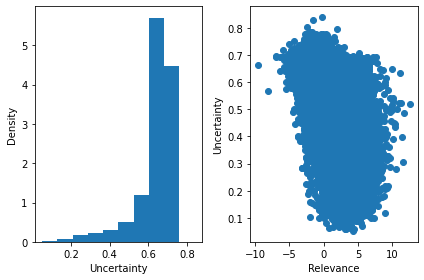

In [11]:
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint('checkpoints/UMF-GPR-notailchasing/bs = 600-embedding_dim=200-embedding_dim_var=33-lr=0.00032381228433606905-weight_decay=8.769177958430606e-05-epoch=39-val_likelihood=0.8606168031692505.ckpt')
results = test_uncertain(model, data, max_k=10, name='UMF-GPR-run2')

clear_output(wait=True)
print(results)

{'FCP': 0.8500678962229583, 'CP unc': 0.75533444, 'DP unc': 0.72948426, 'PUR': 1.0354363, 'corr_usup': -0.4515943750068395, 'corr_isup': -0.3262289389968925, 'MAP': array([0.02073339, 0.02815903, 0.03200395, 0.03417787, 0.03619165,
       0.03761191, 0.0385711 , 0.03942556, 0.03992714, 0.0404262 ],
      dtype=float32), 'Recall': array([0.00544802, 0.00918151, 0.01194522, 0.01439424, 0.01721086,
       0.01994363, 0.02202809, 0.02418352, 0.02582265, 0.02792798],
      dtype=float32), 'UAC': -0.1330729918350432, 'URI': 0.09120108187198639, 'MAP-covered': array([0.0404262 , 0.04078172, 0.04263246, 0.0449837 , 0.0483845 ,
       0.05234608, 0.05708472, 0.06389194, 0.07555997, 0.09941914])}


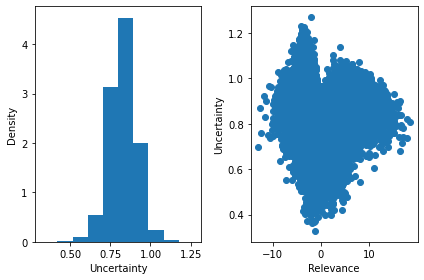

In [16]:
model = UncertainMF(data.n_user, data.n_item, 1, 1, 1, 1).load_from_checkpoint('checkpoints/UMF-GPR-notailchasing/bs = 291-embedding_dim=200-embedding_dim_var=19-lr=3.4076359808269026e-05-weight_decay=5.379903267837132e-05-epoch=64-val_likelihood=0.8362774848937988.ckpt')
results = test_uncertain(model, data, max_k=10, name='UMF-GPR-run-bad')

clear_output(wait=True)
print(results)

# Results

In [17]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['MF-BPR', 'UMF-GPR-run0', 'UMF-GPR-run1', 'UMF-GPR-run2', 'UMF-GPR-run-bad']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*']
lines = {k: '-' + l for k, l, in zip(results, lines)}

# Results
results[['FCP', 'CP unc', 'DP unc', 'PUR', 'URI', 'UAC']]

,FCP,CP unc,DP unc,PUR,URI,UAC
MF-BPR,0.870386,NaN,NaN,NaN,NaN,NaN
UMF-GPR-run0,0.871220,0.354142,0.565056,0.626739,0.027952,-0.208441
UMF-GPR-run1,0.870372,0.287321,0.519656,0.552905,-0.076722,-0.191244
UMF-GPR-run2,0.871507,0.402321,0.586265,0.686244,-0.017917,-0.174472
UMF-GPR-run-bad,0.850068,0.755334,0.729484,1.035436,0.091201,-0.133073


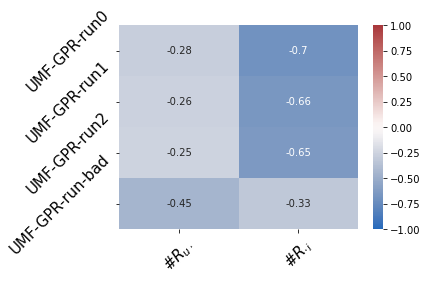

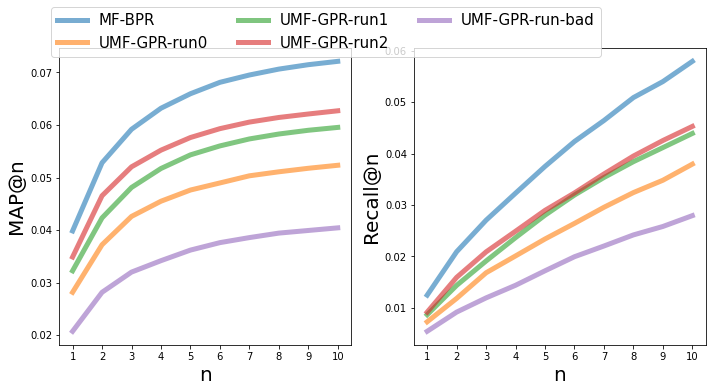

In [18]:
## Correlation plot
corr = results.drop('MF-BPR', axis=0).filter(like='corr', axis=1)
corr.columns = [r'#$R_{u\cdot}$', r'#$R_{\cdot i}$']
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=3, bbox_to_anchor=(0.85, 1.1))
f.tight_layout()
f.savefig('plots/accuracy.pdf', bbox_inches="tight")

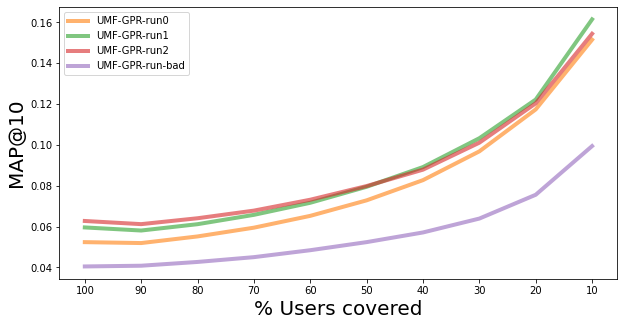

In [19]:
f, ax = plt.subplots(figsize=(10, 5))
for index, row in results.drop(['MF-BPR'], axis=0).iterrows():
    ax.plot(np.arange(1, 11), row['MAP-covered'], '-', color=colors[index], label=index, linewidth=4, alpha=0.6)
ax.set_xticks(np.arange(1, 11))
ax.set_xticklabels(np.linspace(100, 10, 10).astype(np.int8))
ax.set_xlabel('% Users covered', fontsize=20)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend()